In [1]:
import pandas as pd
import matplotlib.pyplot  as plt
import os
import gluonts.torch
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator


d:\TS\venv\lib\site-packages\gluonts\json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


### Подготовка данных для использования нейросетью

In [2]:
data = pd.read_csv('calm_p.csv')

In [3]:
data.head()

,Time,1,2,3,4,5,6
0,10.000,1.378625,-0.240078,-0.297721,1.860784,1.918431,-0.268704
1,10.001,1.379017,-0.242431,-0.301250,1.861176,1.920000,-0.271841
2,10.002,1.379802,-0.244000,-0.304387,1.861176,1.921569,-0.274194
3,10.003,1.379802,-0.244000,-0.304387,1.861176,1.921569,-0.274194
4,10.004,1.380586,-0.242039,-0.303995,1.860000,1.921961,-0.272625


In [4]:
data.index = pd.to_datetime(data.index, unit = 's')

In [5]:
data.index

DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 00:00:01',
               '1970-01-01 00:00:02', '1970-01-01 00:00:03',
               '1970-01-01 00:00:04', '1970-01-01 00:00:05',
               '1970-01-01 00:00:06', '1970-01-01 00:00:07',
               '1970-01-01 00:00:08', '1970-01-01 00:00:09',
               ...
               '1970-01-01 13:53:10', '1970-01-01 13:53:11',
               '1970-01-01 13:53:12', '1970-01-01 13:53:13',
               '1970-01-01 13:53:14', '1970-01-01 13:53:15',
               '1970-01-01 13:53:16', '1970-01-01 13:53:17',
               '1970-01-01 13:53:18', '1970-01-01 13:53:19'],
              dtype='datetime64[ns]', length=50000, freq=None)

In [6]:
data.drop('Time', axis = 1, inplace = True)

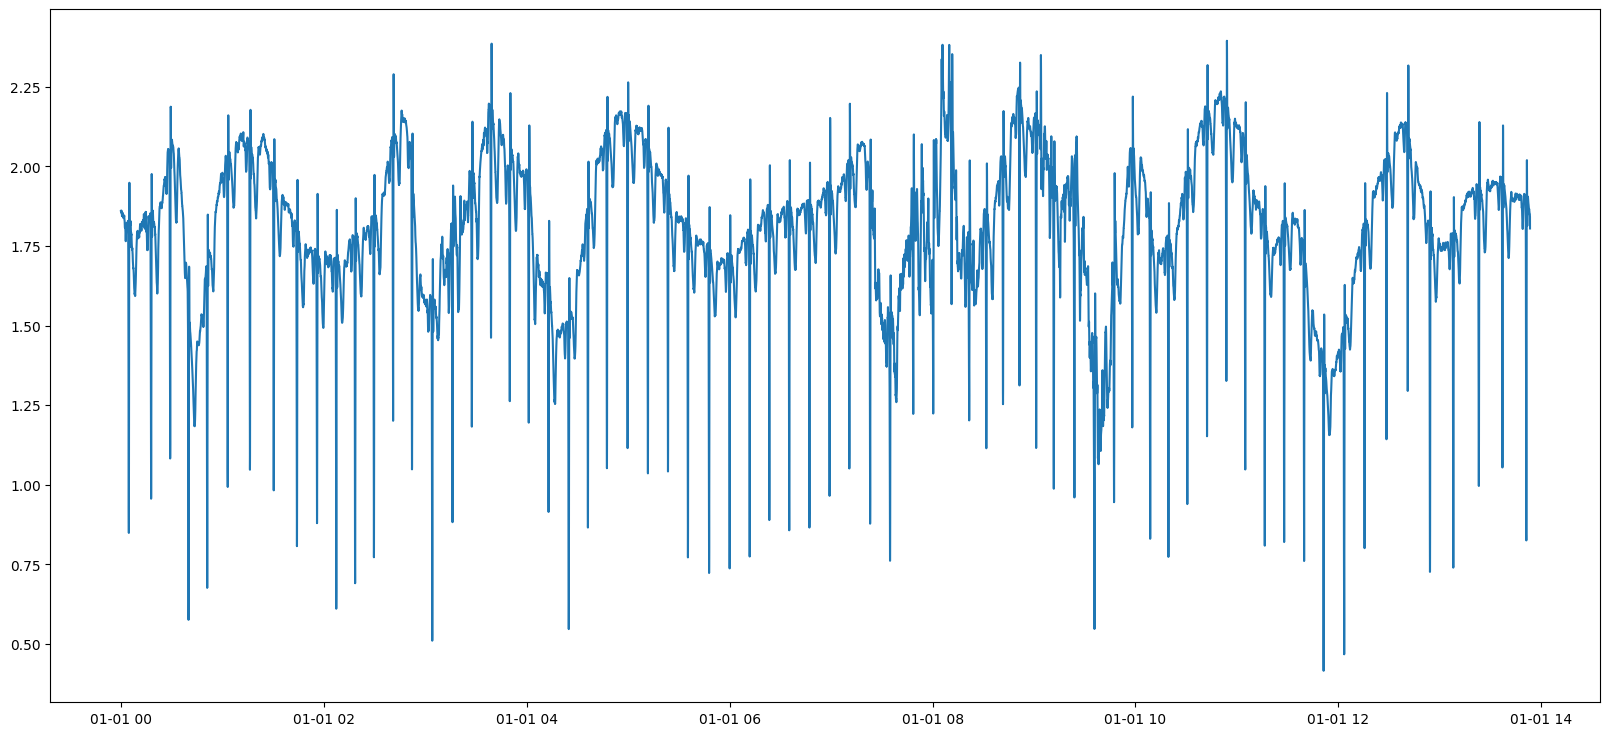

In [7]:
plt.figure(figsize=(20,9))
plt.plot(data['4'])

In [8]:
print(pd.infer_freq(data.index))

S


In [9]:
pdts_data = PandasDataset(data, target = '4')
train,test = split(pdts_data, offset=-2500)

In [10]:
test = test.generate_instances(prediction_length = 2500, windows=1)

In [11]:
import numpy as np
import torch.optim as optim
import torch.utils.data as torch_data
 
model = DeepAREstimator(freq = '10min', prediction_length=2500, trainer_kwargs={'max_epochs':5})

EPOCHS = 1

In [12]:
predictor = model.train(train)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\TS\venv\lib\site-packages\lightning\pytorch\trainer\connectors\logger_connector\logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
d:\TS\venv\lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | In sizes                                                           | Out sizes     
-----------------------------------------------------

Epoch 0: |          | 50/? [01:20<00:00,  0.62it/s, v_num=10, train_loss=0.766]

Epoch 0, global step 50: 'train_loss' reached 0.76564 (best 0.76564), saving model to 'd:\\TS\\Timeseries-Tasks\\HW13\\lightning_logs\\version_10\\checkpoints\\epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [01:16<00:00,  0.66it/s, v_num=10, train_loss=-.530]

Epoch 1, global step 100: 'train_loss' reached -0.52992 (best -0.52992), saving model to 'd:\\TS\\Timeseries-Tasks\\HW13\\lightning_logs\\version_10\\checkpoints\\epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [01:15<00:00,  0.66it/s, v_num=10, train_loss=-.900]

Epoch 2, global step 150: 'train_loss' reached -0.90029 (best -0.90029), saving model to 'd:\\TS\\Timeseries-Tasks\\HW13\\lightning_logs\\version_10\\checkpoints\\epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [01:19<00:00,  0.63it/s, v_num=10, train_loss=-.725]

Epoch 3, global step 200: 'train_loss' was not in top 1


Epoch 4: |          | 50/? [01:24<00:00,  0.59it/s, v_num=10, train_loss=-.840]

Epoch 4, global step 250: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: |          | 50/? [01:24<00:00,  0.59it/s, v_num=10, train_loss=-.840]


Описывается функция для обучения

#### Запуск обучения нейросети

Сохранение обученной сети

In [13]:
forecast = list(predictor.predict(test.input))

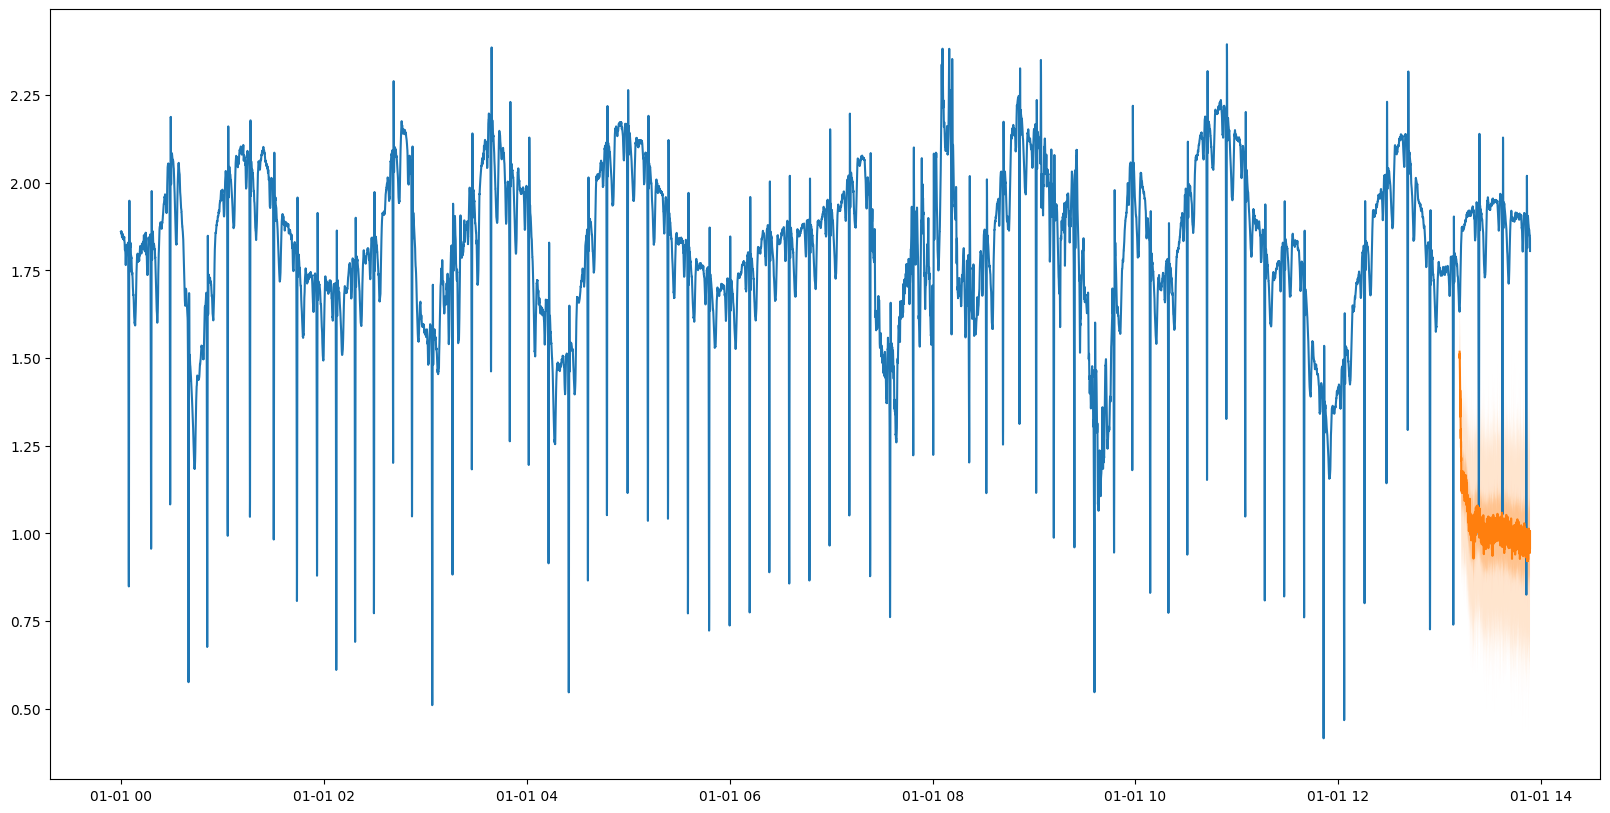

In [14]:
plt.figure(figsize=(20,10))
plt.plot(data['4'])
for fore in forecast:
    fore.plot()

In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

In [17]:
def smape( data , pred ):
 return 1/ len (data) * np.sum (2 * np.abs (pred-data) / (np.abs (data) + np.abs (pred)))

In [20]:
offset = 2500
predictions = forecast[-1].samples[-1]

In [21]:
print("RMSE:", np.sqrt(mean_squared_error(data['4'][len(data['4'])-offset:], predictions)))
print("MAPE:", mean_absolute_percentage_error(data['4'][len(data['4'])-offset:], predictions))
print("MAE:", mean_absolute_error(data['4'][len(data['4'])-offset:], predictions))
print("R2: ", r2_score(data['4'][len(data['4'])-offset:], predictions))
print("SMAPE: ", smape(data['4'][len(data['4'])-offset:], predictions))

RMSE: 0.904337401662178
MAPE: 0.46063191613816123
MAE: 0.8691305284956347
R2:  -44.161634220516575
SMAPE:  0.6128895300071707
